Dataset: https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset

Columns:
    
step: represents a unit of time where 1 step equals 1 hour  
type: type of online transaction  
amount: the amount of the transaction  
nameOrig: customer starting the transaction  
oldbalanceOrg: balance before the transaction  
newbalanceOrig: balance after the transaction  
nameDest: recipient of the transaction  
oldbalanceDest: initial balance of recipient before the transaction  
newbalanceDest: the new balance of recipient after the transaction  
isFraud: fraud transaction  

# 1 Importação de bibliotecas

In [1]:
#Manipulação de dados
import pandas as pd
import numpy as np

#Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import get_ipython
import warnings
warnings.filterwarnings("ignore")

# Prototipação
from lazypredict.Supervised import LazyClassifier

#Balanceamento de dados
from imblearn.under_sampling import NearMiss

#ML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#Tuning
from sklearn.model_selection import GridSearchCV

#Model evaluation
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 2 Leitura dos dados

In [2]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0


# 3 Limpeza

## 3.1 Missing

In [4]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

## 3.2 Duplicados

In [5]:
df.duplicated().sum()

0

## 3.3 Unicos

In [6]:
df.nunique()

step                  743
type                    5
amount            5316900
nameOrig          6353307
oldbalanceOrg     1845844
newbalanceOrig    2682586
nameDest          2722362
oldbalanceDest    3614697
newbalanceDest    3555499
isFraud                 2
isFlaggedFraud          2
dtype: int64

## 3.4 Dados categóricos

In [7]:
df_categorical = df[['type','isFraud','isFlaggedFraud']]

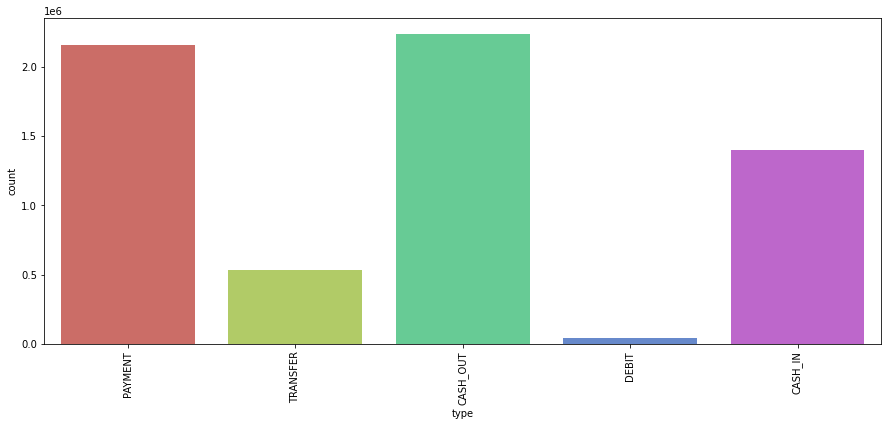

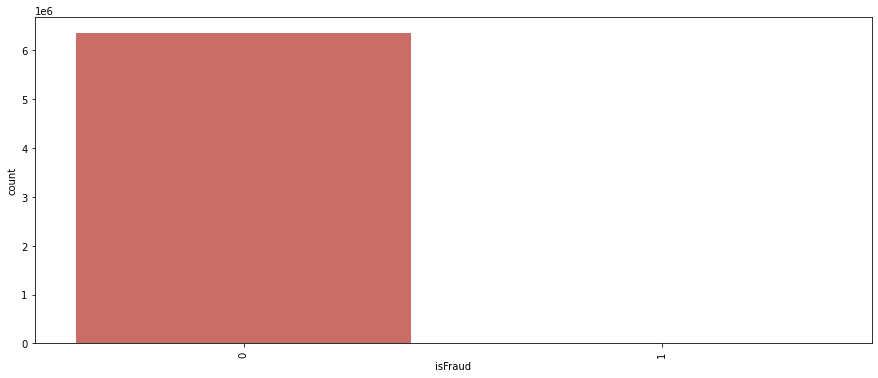

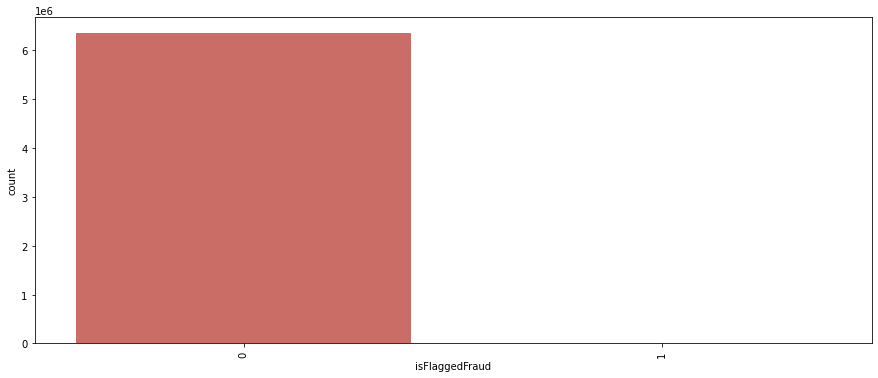

In [8]:
for i in df_categorical.columns:
    plt.figure(figsize=(15,6))
    sns.countplot(df_categorical[i], data = df_categorical,
    palette='hls')
    plt.xticks(rotation = 90)
    plt.show()


## 3.5 Dados numericos

In [9]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [8]:
df_numerico = df[['step','amount','oldbalanceOrg','newbalanceOrig', 'oldbalanceDest','newbalanceDest','isFraud','isFlaggedFraud']]

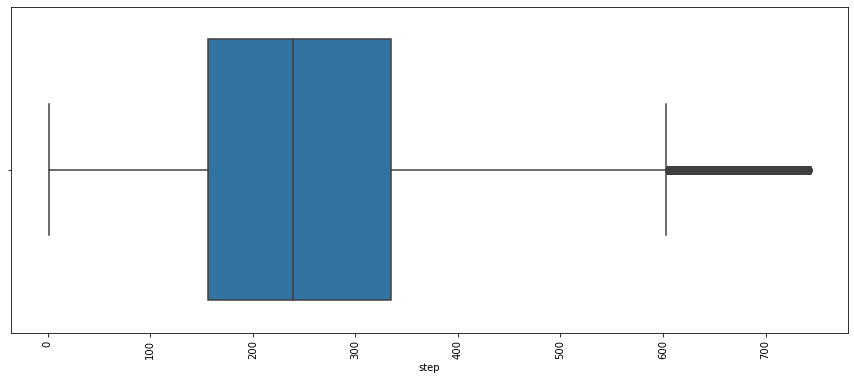

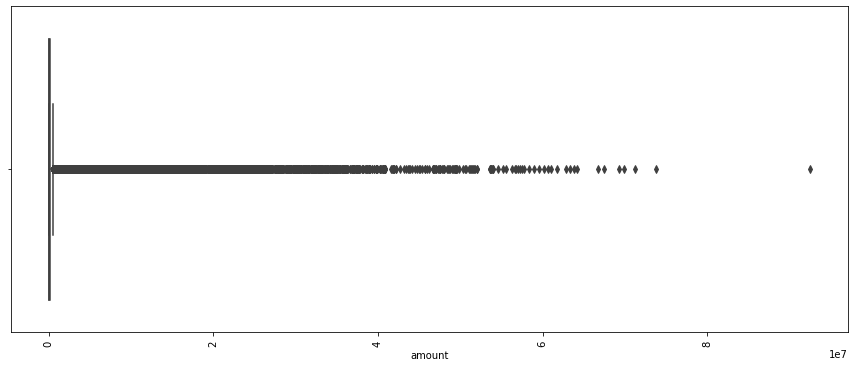

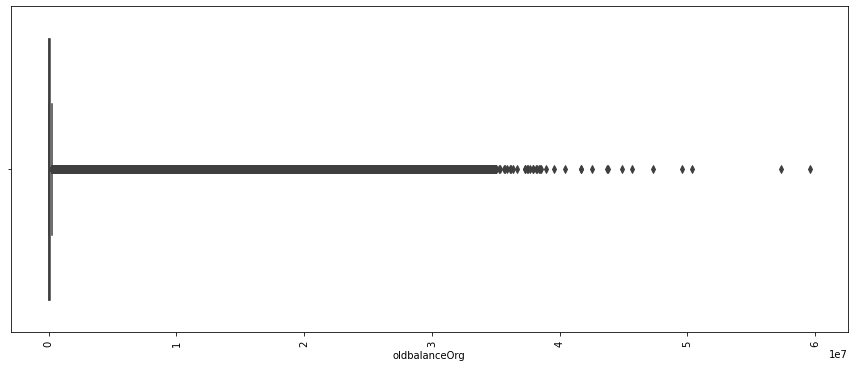

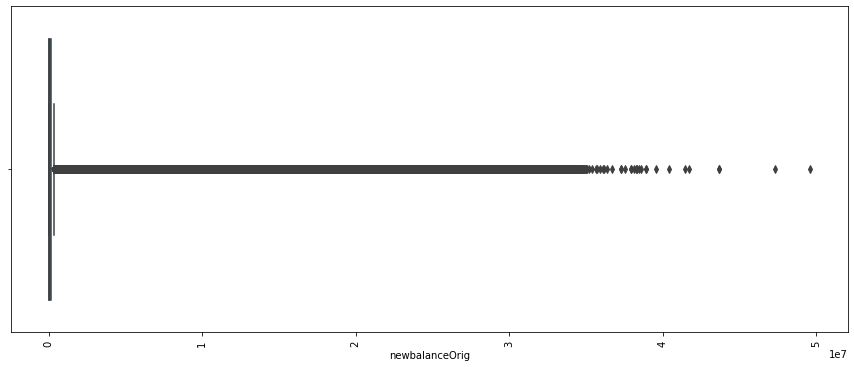

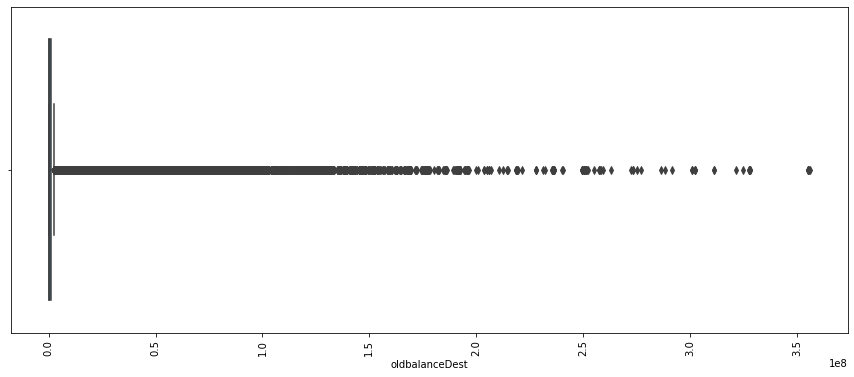

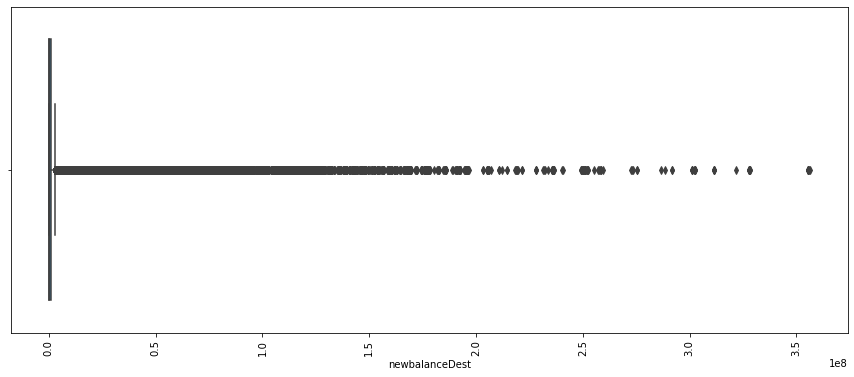

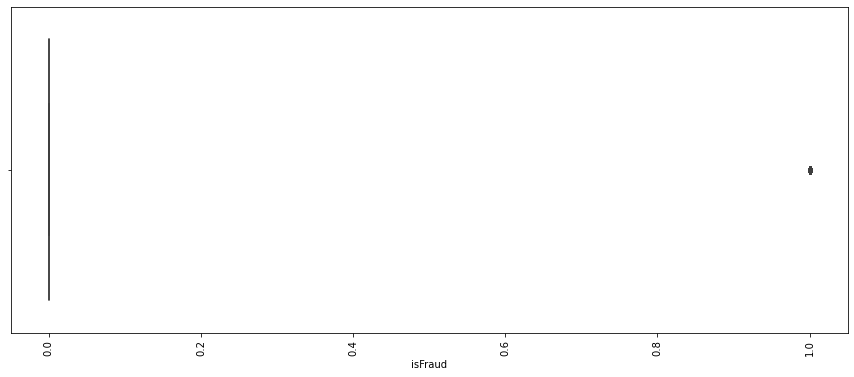

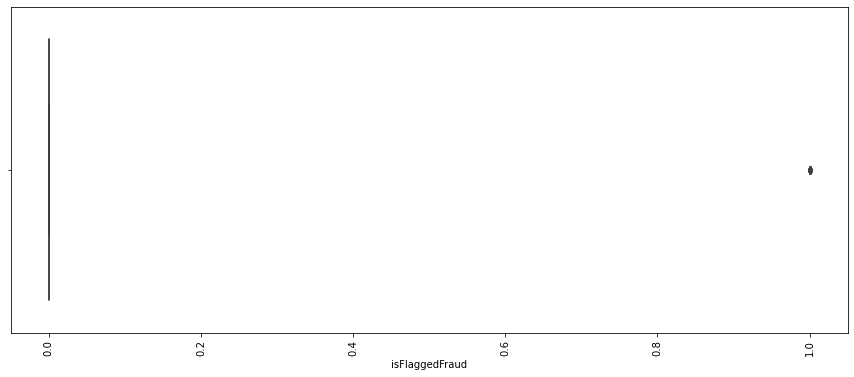

In [11]:
for i in df_numerico.columns:
    plt.figure(figsize=(15,6))
    sns.boxplot(df[i], data = df)
    plt.xticks(rotation = 90)
    plt.show()


# 4 Criação de features e Analise de Dados

In [9]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00
mean,243.40,179861.90,833883.10,855113.67,1100701.67,1224996.40,0.00,0.00
std,142.33,603858.23,2888242.67,2924048.50,3399180.11,3674128.94,0.04,0.00
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,156.00,13389.57,0.00,0.00,0.00,0.00,0.00,0.00
50%,239.00,74871.94,14208.00,0.00,132705.66,214661.44,0.00,0.00
75%,335.00,208721.48,107315.18,144258.41,943036.71,1111909.25,0.00,0.00
max,743.00,92445516.64,59585040.37,49585040.37,356015889.35,356179278.92,1.00,1.00


In [10]:
df_final = df.copy()

## 4.1 Variação % balanço conta de origem e de destino

In [11]:
# Quantos % diminuiu da conta que foi realizado a transferência
df_final['varOrig'] = -1 * (df_final['oldbalanceOrg'] - df_final['newbalanceOrig']) / (df_final['oldbalanceOrg'])

# Quantos % aumentou da conta que a transferência foi recebida
df_final['varDest'] = (df_final['newbalanceDest'] - df_final['oldbalanceDest']) / (df_final['newbalanceDest'])
df_final.isnull().sum()

step                    0
type                    0
amount                  0
nameOrig                0
oldbalanceOrg           0
newbalanceOrig          0
nameDest                0
oldbalanceDest          0
newbalanceDest          0
isFraud                 0
isFlaggedFraud          0
varOrig           2088985
varDest           2317282
dtype: int64

In [ ]:
## Tratando valores de variação NaN ou inf (ocorre quando o denominador for zero no calculo acima)
df_final['varOrig'] = df_final['varOrig'].apply(lambda x: 0 if np.isnan(x) else x)
df_final['varOrig'] = df_final['varOrig'].apply(lambda x: 1 if np.isinf(x) else x)

df_final['varDest'] = df_final['varDest'].apply(lambda x: 0 if np.isnan(x) else x)
df_final['varDest'] = df_final['varDest'].apply(lambda x: -1 if np.isinf(x) else x)
df_final.isnull().sum()

In [ ]:
df_final.head(10)

## 4.2 Balanceamento dados

In [ ]:
sns.catplot(x="isFraud",
                data=df_final,
                kind="count", height=3.5, aspect=.8)

In [ ]:
df_final.isFraud.value_counts()

In [ ]:
df_final.isFraud.value_counts()[1]/(df_final.isFraud.value_counts()[0]+df_final.isFraud.value_counts()[1])

Fraudes representam apenas 1.29% do dataset a base é altamente desbalanceada

## 4.3 Analise Bivariada

In [21]:
sns.pairplot(df_final)
plt.show()

## 4.4 Correlação variáveis e target

In [22]:
df_final.corr().sort_values(by = 'isFraud', ascending = False)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,varOrig,varDest
isFraud,0.03,0.08,0.01,-0.01,-0.01,0.00,1.00,0.04,-0.00,0.00
amount,0.02,1.00,-0.00,-0.01,0.29,0.46,0.08,0.01,0.00,0.00
isFlaggedFraud,0.00,0.01,0.00,0.00,-0.00,-0.00,0.04,1.00,-0.00,0.00
step,1.00,0.02,-0.01,-0.01,0.03,0.03,0.03,0.00,0.00,0.00
oldbalanceOrg,-0.01,-0.00,1.00,1.00,0.07,0.04,0.01,0.00,-0.01,-0.00
newbalanceDest,0.03,0.46,0.04,0.04,0.98,1.00,0.00,-0.00,-0.00,0.00
varDest,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,1.00
varOrig,0.00,0.00,-0.01,-0.00,-0.00,-0.00,-0.00,-0.00,1.00,0.00
oldbalanceDest,0.03,0.29,0.07,0.07,1.00,0.98,-0.01,-0.00,-0.00,0.00
newbalanceOrig,-0.01,-0.01,1.00,1.00,0.07,0.04,-0.01,0.00,-0.00,-0.00


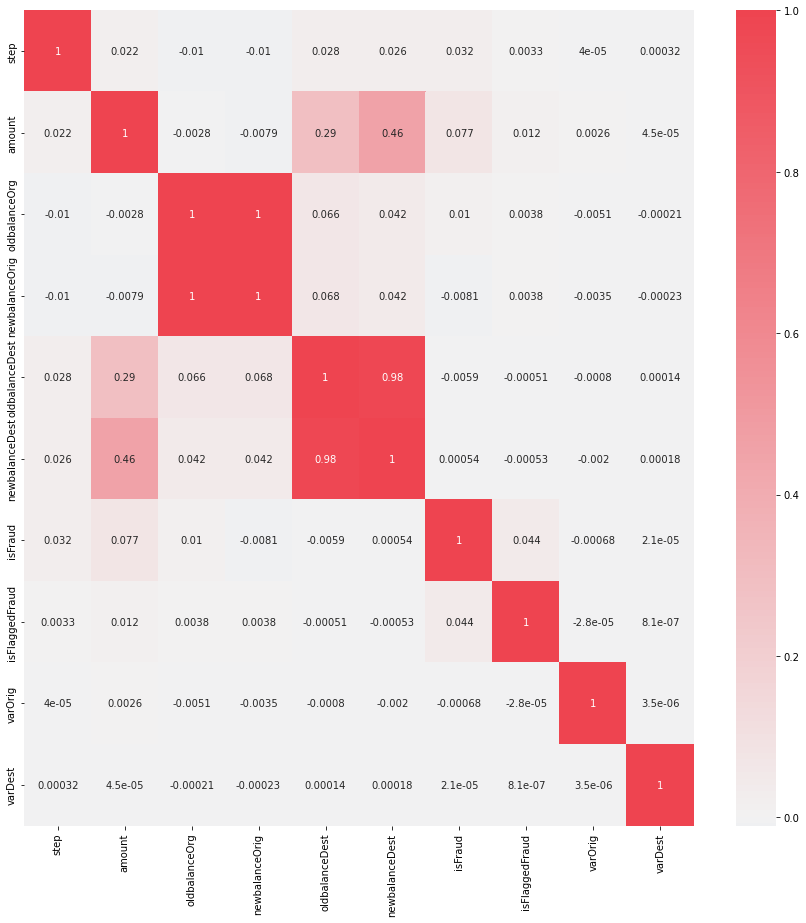

In [23]:
plt.figure(figsize=(15,15))
cmap = sns.diverging_palette(250, 10, s=80, l=55, n=9, as_cmap=True)
sns.heatmap(df_final.corr(),annot=True, cmap=cmap, center=0)
plt.show()


## 4.5 OneHot Encoder

Iremos aplicar onehotEncoder em vez do labelEnconder na variável categorica 'Type' uma vez que é uma variável categórica que possui apenas 5 valores unicos e não possui ordem.

In [27]:
from sklearn.preprocessing import OneHotEncoder

# creating instance of one-hot-encoder
enc = OneHotEncoder()
X = enc.fit_transform(df_final.type.values.reshape(-1,1)).toarray()

#criando df do onehot
df_onehotenc = pd.DataFrame(X, columns = ['type_' + str(int(i)) for i in range(X.shape[1])])

#concatenando ao df original e removendo a coluna residual
df_final = pd.concat([df_final,df_onehotenc], axis = 1)
df_final = df_final.drop(['type'], axis = 1)

In [28]:
df_final.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,varOrig,varDest,type_0,type_1,type_2,type_3,type_4
0,1,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0,-0.06,0.00,0.00,0.00,0.00,1.00,0.00
1,1,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0,-0.09,0.00,0.00,0.00,0.00,1.00,0.00
2,1,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,-1.00,0.00,0.00,0.00,0.00,0.00,1.00
3,1,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0,-1.00,-1.00,0.00,1.00,0.00,0.00,0.00
4,1,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0,-0.28,0.00,0.00,0.00,0.00,1.00,0.00


## 4.6 Normalização colunas numéricas não categóricas

In [29]:
df_final.dtypes

step                int64
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
varOrig           float64
varDest           float64
type_0            float64
type_1            float64
type_2            float64
type_3            float64
type_4            float64
dtype: object

In [30]:
df_numerico_para_normalizar = df_final[['step','amount','oldbalanceOrg','newbalanceOrig', 'oldbalanceDest','newbalanceDest']]

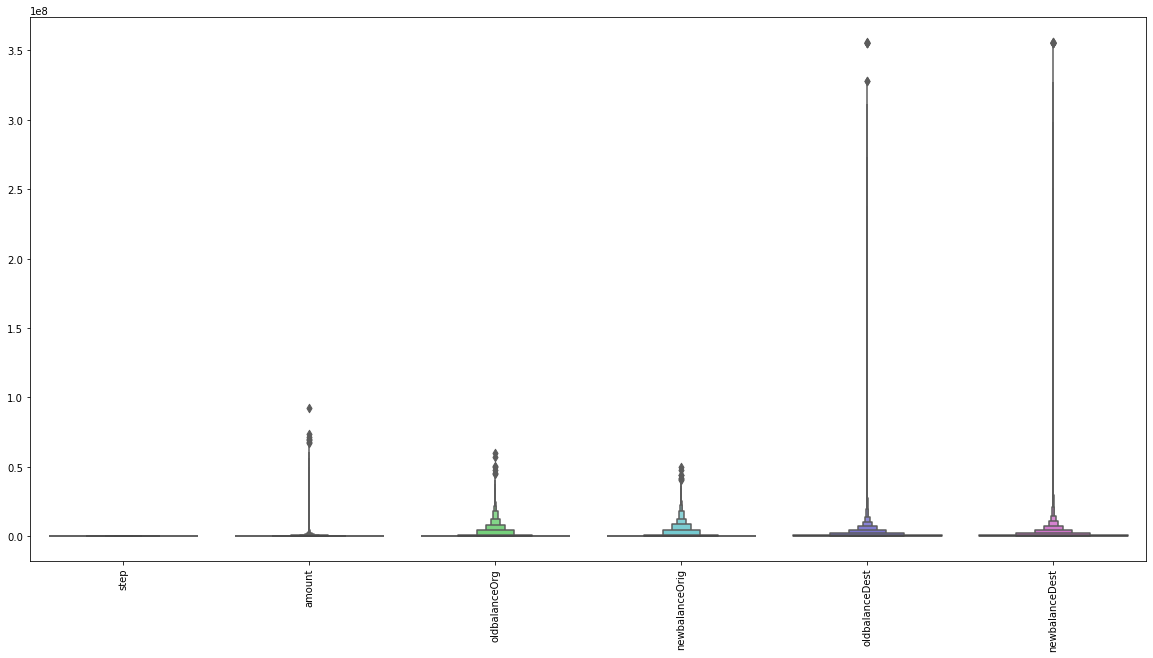

In [31]:
plt.figure(figsize=(20,10))
sns.boxenplot(data = df_numerico_para_normalizar,palette = 'hls')
plt.xticks(rotation=90)
plt.show()

In [32]:
from sklearn.preprocessing import StandardScaler

col_names = list(df_numerico_para_normalizar.columns)
s_scaler = StandardScaler()
df_num_norm = s_scaler.fit_transform(df_numerico_para_normalizar)
df_num_norm = pd.DataFrame(df_num_norm, columns=col_names)
df_num_norm.describe().T

,count,mean,std,min,25%,50%,75%,max
step,6362620.00,0.00,1.00,-1.70,-0.61,-0.03,0.64,3.51
amount,6362620.00,0.00,1.00,-0.30,-0.28,-0.17,0.05,152.79
oldbalanceOrg,6362620.00,0.00,1.00,-0.29,-0.29,-0.28,-0.25,20.34
newbalanceOrig,6362620.00,0.00,1.00,-0.29,-0.29,-0.29,-0.24,16.67
oldbalanceDest,6362620.00,-0.00,1.00,-0.32,-0.32,-0.28,-0.05,104.41
newbalanceDest,6362620.00,-0.00,1.00,-0.33,-0.33,-0.27,-0.03,96.61


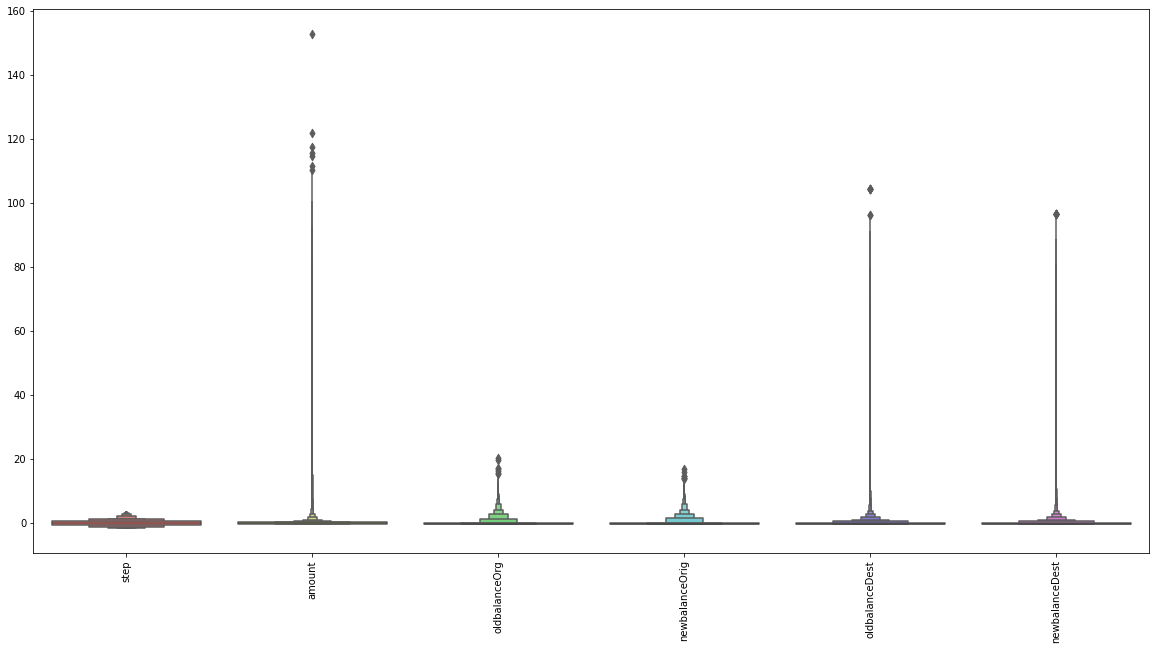

In [33]:
plt.figure(figsize=(20,10))
sns.boxenplot(data = df_num_norm,palette = 'hls')
plt.xticks(rotation=90)
plt.show()

In [34]:
## Substituindo os valores normalizados
df_final_norm = df_num_norm.copy()

#Concatenando os labels e os onehotencoding e as features novas
df_final_norm = pd.concat([df_final_norm,df_final[['type_0','type_1','type_2','type_3','type_4','varOrig','varDest','isFraud']]], axis = 1)


In [35]:
df_final_norm.head(10)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_0,type_1,type_2,type_3,type_4,varOrig,varDest,isFraud
0,-1.70,-0.28,-0.23,-0.24,-0.32,-0.33,0.00,0.00,0.00,1.00,0.00,-0.06,0.00,0
1,-1.70,-0.29,-0.28,-0.29,-0.32,-0.33,0.00,0.00,0.00,1.00,0.00,-0.09,0.00,0
2,-1.70,-0.30,-0.29,-0.29,-0.32,-0.33,0.00,0.00,0.00,0.00,1.00,-1.00,0.00,1
3,-1.70,-0.30,-0.29,-0.29,-0.32,-0.33,0.00,1.00,0.00,0.00,0.00,-1.00,-1.00,1
4,-1.70,-0.28,-0.27,-0.28,-0.32,-0.33,0.00,0.00,0.00,1.00,0.00,-0.28,0.00,0
5,-1.70,-0.28,-0.27,-0.28,-0.32,-0.33,0.00,0.00,0.00,1.00,0.00,-0.15,0.00,0
6,-1.70,-0.29,-0.23,-0.23,-0.32,-0.33,0.00,0.00,0.00,1.00,0.00,-0.04,0.00,0
7,-1.70,-0.28,-0.23,-0.23,-0.32,-0.33,0.00,0.00,0.00,1.00,0.00,-0.04,0.00,0
8,-1.70,-0.29,-0.29,-0.29,-0.32,-0.33,0.00,0.00,0.00,1.00,0.00,-1.00,0.00,0
9,-1.70,-0.29,-0.27,-0.28,-0.31,-0.32,0.00,0.00,1.00,0.00,0.00,-0.13,-0.04,0


# 5 Seleção do modelo e fator de balanceamento.

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score


## 5.1 Amostragem dos dados
minority = 20%  
majority = 80%  

fator = 20/80 = 0.25  

In [36]:
#Definição dos dados
X = df_final_norm.drop(["isFraud"],axis=1)
y = df_final_norm["isFraud"]
        
#Aplicando balanceamento    
nr = NearMiss(sampling_strategy = 0.25)
X, y = nr.fit_resample(X, y)

y.value_counts()

0    32852
1     8213
Name: isFraud, dtype: int64

## 5.2 Separação da amostra para validação ( Amostragem Inicial )

In [100]:
X_valid = X
y_valid = y

## 5.3 Seleção do modelo

In [49]:
df_models = pd.DataFrame()
fator_balanceamento = np.linspace(0.42,0.99,10).tolist()

#numero de repetições do experimento
for i in range(5):
    
    #Balanceamento
    for fator in fator_balanceamento:
        
        #Acompanhamento do andamento dos experimentos
        print(i+1,fator)
        
        #Aplicando balanceamento    
        nr = NearMiss(sampling_strategy = fator)
        X_balanceado, y_balanceado = nr.fit_resample(X, y)
        
        #Holdout
        X_train, X_test, y_train, y_test = train_test_split(X_balanceado, y_balanceado,test_size=0.3,random_state = i)
        
        #Treinando algoritmos e armazenando os resultados
        clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
        models,predictions = clf.fit(X_train, X_test, y_train, y_test)
        models['fator'] = fator
        df_models = df_models.append(models.reset_index(), ignore_index=True)




1 0.42


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [02:21<00:00,  4.89s/it]


1 0.48333333333333334


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [01:34<00:00,  3.26s/it]


1 0.5466666666666666


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [01:17<00:00,  2.68s/it]


1 0.61


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [01:03<00:00,  2.19s/it]


1 0.6733333333333333


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:53<00:00,  1.84s/it]


1 0.7366666666666667


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:46<00:00,  1.61s/it]


1 0.8


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:45<00:00,  1.57s/it]


1 0.8633333333333333


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:33<00:00,  1.15s/it]


1 0.9266666666666667


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:33<00:00,  1.14s/it]


1 0.99


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:29<00:00,  1.00s/it]


2 0.42


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [01:58<00:00,  4.10s/it]


2 0.48333333333333334


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [01:20<00:00,  2.79s/it]


2 0.5466666666666666


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:58<00:00,  2.00s/it]


2 0.61


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:47<00:00,  1.63s/it]


2 0.6733333333333333


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:45<00:00,  1.55s/it]


2 0.7366666666666667


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:37<00:00,  1.30s/it]


2 0.8


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:35<00:00,  1.21s/it]


2 0.8633333333333333


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:35<00:00,  1.21s/it]


2 0.9266666666666667


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:30<00:00,  1.04s/it]


2 0.99


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:28<00:00,  1.01it/s]


3 0.42


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [01:50<00:00,  3.83s/it]


3 0.48333333333333334


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [01:11<00:00,  2.48s/it]


3 0.5466666666666666


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:56<00:00,  1.93s/it]


3 0.61


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:46<00:00,  1.61s/it]


3 0.6733333333333333


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:41<00:00,  1.44s/it]


3 0.7366666666666667


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:37<00:00,  1.30s/it]


3 0.8


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:35<00:00,  1.21s/it]


3 0.8633333333333333


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:32<00:00,  1.11s/it]


3 0.9266666666666667


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:30<00:00,  1.05s/it]


3 0.99


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:28<00:00,  1.02it/s]


4 0.42


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [01:44<00:00,  3.61s/it]


4 0.48333333333333334


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [01:12<00:00,  2.51s/it]


4 0.5466666666666666


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:56<00:00,  1.96s/it]


4 0.61


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:46<00:00,  1.61s/it]


4 0.6733333333333333


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:44<00:00,  1.53s/it]


4 0.7366666666666667


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:38<00:00,  1.34s/it]


4 0.8


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:35<00:00,  1.22s/it]


4 0.8633333333333333


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:34<00:00,  1.18s/it]


4 0.9266666666666667


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:30<00:00,  1.05s/it]


4 0.99


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:28<00:00,  1.00it/s]


5 0.42


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [01:40<00:00,  3.46s/it]


5 0.48333333333333334


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [01:13<00:00,  2.54s/it]


5 0.5466666666666666


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:56<00:00,  1.95s/it]


5 0.61


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:49<00:00,  1.69s/it]


5 0.6733333333333333


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:41<00:00,  1.44s/it]


5 0.7366666666666667


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:38<00:00,  1.31s/it]


5 0.8


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:35<00:00,  1.21s/it]


5 0.8633333333333333


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:32<00:00,  1.11s/it]


5 0.9266666666666667


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:30<00:00,  1.06s/it]


5 0.99


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:29<00:00,  1.01s/it]


In [50]:
pd.set_option('display.precision',5)

In [51]:
pd.reset_option('^display.',silent=True)

In [52]:
df_models.groupby(['Model','fator']).agg({'Accuracy':np.mean, 'Balanced Accuracy':np.mean, 'ROC AUC':np.mean, 'F1 Score':np.mean}).sort_values(by='Balanced Accuracy', ascending=False).head(50)

Accuracy  Balanced Accuracy   ROC AUC  \
Model                  fator                                             
XGBClassifier          0.863333  0.988567           0.988342  0.988342   
                       0.673333  0.989417           0.988276  0.988276   
                       0.736667  0.989120           0.988261  0.988261   
                       0.800000  0.988420           0.987867  0.987867   
LGBMClassifier         0.863333  0.988078           0.987816  0.987816   
                       0.736667  0.988294           0.987474  0.987474   
XGBClassifier          0.990000  0.987442           0.987423  0.987423   
                       0.483333  0.990188           0.987376  0.987376   
LGBMClassifier         0.800000  0.987734           0.987137  0.987137   
                       0.990000  0.987119           0.987105  0.987105   
                       0.673333  0.988306           0.987102  0.987102   
XGBClassifier          0.546667  0.988983           0.986754  0.986754   
LGBMClassifier         0.546667  0.988811           0.986586  0.986586   
XGBClassifier          0.926667  0.986648           0.986522  0.986522   
LGBMClassifier         0.610000  0.987944           0.986388  0.986388   
XGBClassifier          0.420000  0.990061           0.986325  0.986325   
                       0.610000  0.987698           0.986061  0.986061   
LGBMClassifier         0.483333  0.989051           0.986006  0.986006   
                       0.926667  0.985711           0.985574  0.985574   
                       0.420000  0.988813           0.984669  0.984669   
ExtraTreesClassifier   0.736667  0.985953           0.984404  0.984404   
                       0.863333  0.984205           0.983692  0.983692   
RandomForestClassifier 0.990000  0.983687           0.983673  0.983673   
ExtraTreesClassifier   0.990000  0.983525           0.983510  0.983510   
RandomForestClassifier 0.736667  0.984920           0.983508  0.983508   
                       0.863333  0.983528           0.983094  0.983094   
                       0.673333  0.984811           0.982943  0.982943   
ExtraTreesClassifier   0.673333  0.985138           0.982885  0.982885   
RandomForestClassifier 0.800000  0.983766           0.982830  0.982830   
                       0.610000  0.984684           0.982235  0.982235   
ExtraTreesClassifier   0.926667  0.982432           0.982196  0.982196   
RandomForestClassifier 0.926667  0.982315           0.982128  0.982128   
ExtraTreesClassifier   0.800000  0.983261           0.982028  0.982028   
BaggingClassifier      0.990000  0.981991           0.981979  0.981979   
RandomForestClassifier 0.546667  0.985081           0.981681  0.981681   
                       0.483333  0.985930           0.981672  0.981672   
ExtraTreesClassifier   0.546667  0.985454           0.981626  0.981626   
RandomForestClassifier 0.420000  0.986604           0.981512  0.981512   
BaggingClassifier      0.673333  0.982786           0.981007  0.981007   
                       0.736667  0.982234           0.980969  0.980969   
                       0.800000  0.981710           0.980821  0.980821   
ExtraTreesClassifier   0.610000  0.983977           0.980819  0.980819   
BaggingClassifier      0.483333  0.984660           0.980716  0.980716   
ExtraTreesClassifier   0.483333  0.985771           0.980633  0.980633   
                       0.420000  0.986700           0.980408  0.980408   
BaggingClassifier      0.863333  0.980557           0.980215  0.980215   
                       0.610000  0.982316           0.980109  0.980109   
                       0.926667  0.979777           0.979603  0.979603   
                       0.546667  0.982556           0.979262  0.979262   
DecisionTreeClassifier 0.990000  0.979164           0.979156  0.979156   

                                 F1 Score  
Model                  fator               
XGBClassifier          0.863333  0.988565  
                       0.673333  0.989409  
        

O modelo random forest ingênuo atingiu acurácia de 98% com dados de treino 50% transações normais e 50% fraudes (fator de balanceamento = 0.99 = 1. utilizando todas as features

- Modelo: Random Forest
- Fator de Balanceamento: 1

## Rebalanceando a amostra 50% / 50% - Aplicando fator de balanceamento = 1:

In [101]:
y_valid.value_counts()

0    32852
1     8213
Name: isFraud, dtype: int64

In [102]:
nr = NearMiss()
X_balanc, y_balanc = nr.fit_resample(X_valid, y_valid)

In [103]:
y_balanc.value_counts()

1    8213
0    8213
Name: isFraud, dtype: int64

# 6 Seleção de features - Random Forest

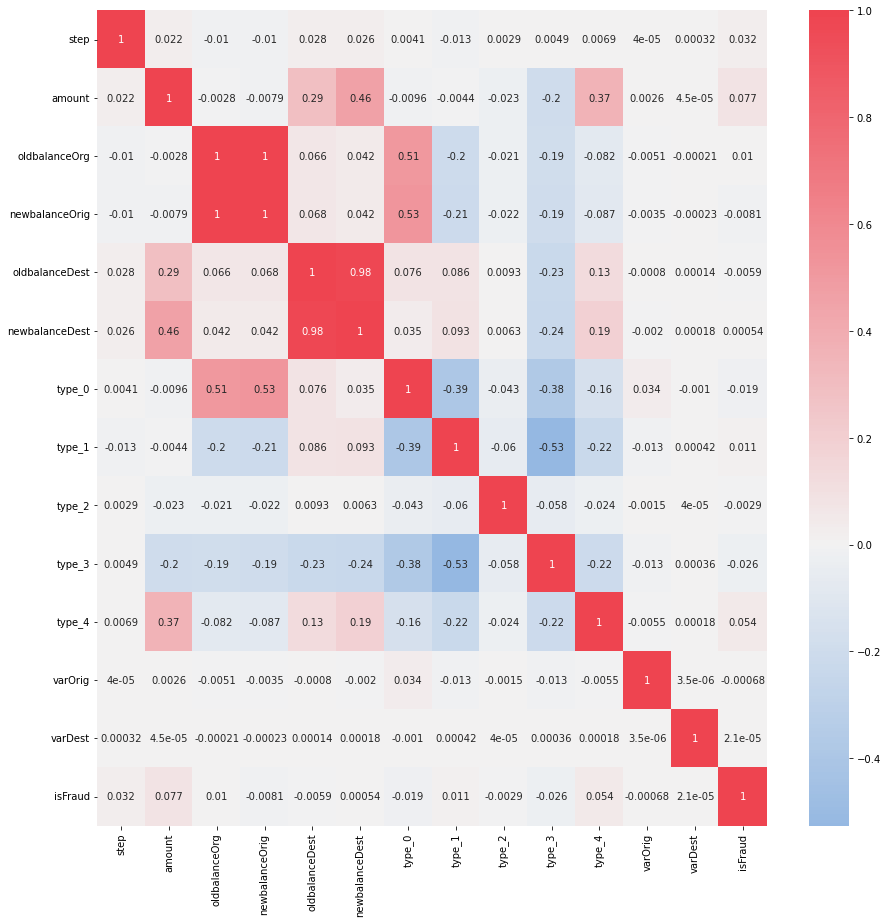

In [96]:
plt.figure(figsize=(15,15))
cmap = sns.diverging_palette(250, 10, s=80, l=55, n=9, as_cmap=True)
sns.heatmap(df_final_norm.corr(),annot=True, cmap=cmap, center=0)
plt.show()

In [99]:
df_final_norm.corr().sort_values(by = 'isFraud', ascending = False)['isFraud']

isFraud           1.000000
amount            0.076688
type_4            0.053869
step              0.031578
type_1            0.011256
oldbalanceOrg     0.010154
newbalanceDest    0.000535
varDest           0.000021
varOrig          -0.000677
type_2           -0.002911
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
type_0           -0.019089
type_3           -0.025697
Name: isFraud, dtype: float64

 Ordem de das features mais correlacionados: 
        
        - amount, type_4, type_3, type_0, type_1, oldbalanceOrg ,newbalanceOrig, oldbalanceDest, newbalanceDest, type_2, varOrig , varDest  

In [109]:
acuracia_dados = make_scorer(accuracy_score)
f1_dados = make_scorer(f1_score)
balanced_acc_dados = make_scorer(balanced_accuracy_score)
scoring = {"accuracy": acuracia_dados, "f1":f1_dados, "bacuracy":balanced_acc_dados}
resultados = []

In [129]:
## hiperparametros default do randomforest com o fator de balanceamento definido na etapa 5.3
fator_balanceamento = [1]
max_depth = [None]
min_samples_split = [2]
min_samples_leaf = [1] 
criterion = ['gini']

features = ['amount','type_4','type_3','type_0','type_1','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','type_2','varOrig','varDest']
features = ['amount','type_4','type_3','type_0','type_1','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','type_2','varOrig']
features = ['amount','type_4','type_3','type_0','type_1','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','type_2']
features = ['amount','type_4','type_3','type_0','type_1','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','varOrig']
features = ['amount','type_4','type_3','type_0','type_1','oldbalanceOrg','newbalanceOrig','oldbalanceDest','type_2','varOrig'] ##
features = ['amount','type_4','type_3','type_0','type_1','oldbalanceOrg','newbalanceOrig','oldbalanceDest','type_2']
features = ['amount','type_4','type_3','type_0','type_1','oldbalanceOrg','newbalanceOrig','oldbalanceDest','varOrig'] 
features = ['amount','type_4','type_3','type_0','type_1','oldbalanceOrg','newbalanceOrig','type_2','varOrig'] ##
features = ['amount','type_4','type_3','type_0','type_1','oldbalanceOrg','type_2','varOrig']
features = ['amount','type_4','type_3','type_0','type_1','newbalanceOrig','type_2','varOrig'] 


# Numero de repetições do experimento
for i in range(5): 
    
    
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
    
    print("Fazendo gridsearch - Repeticao %s" % (i+1))
    
    
    # itera sobre parametro 1:
    for k in max_depth:

        
        # itera sobre parametro 2:
        for u in min_samples_split:
            
            #itera sobre o parametro 3:
            for w in min_samples_leaf:
                
                #itera sobre parametro 4
                for v in criterion:
                    
                    for fator in fator_balanceamento:
                        #print(fator)
                        #print("Fazendo gridsearch - Repeticao %s" %(i+1))
                        
                        #Selecionando apenas as features de interesse:
                        X_features = X_balanc[features]

                        #Separação em dados de 70% treino e 30% teste
                        X_train, X_test, y_train, y_test = train_test_split(X_features, y_balanc, test_size=0.3, random_state=i, stratify=y_balanc)
                        
                        gs = GridSearchCV(
                                RandomForestClassifier(random_state=i) ,
                                param_grid={"max_depth": [k], 
                                            "min_samples_split":[u],
                                            "min_samples_leaf":[w],
                                            "criterion":[v]}, 
                                scoring=scoring,
                                refit="bacuracy",
                                n_jobs=2,
                                return_train_score=True,
                                cv = kfold
                                    )
                            
                        #gs = RandomForestClassifier(random_state=i)

                        #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
                        gs.fit(X_train, y_train)

                        #Melhores resultados e hiperparâmetros encontrados
                           
                        #acuracy_treino = gs.best_score_
                        scoretreino = gs.score(X_train,y_train)
                            
                        ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
                        y_test_pred = gs.predict(X_test)
                        y_valid_pred = gs.predict(X_valid[features])

                            
                        #Calculando acurácia 
                        accuracy_teste = accuracy_score(y_test, y_test_pred)
                        acuracy_valid = accuracy_score(y_valid, y_valid_pred)
                        
                        #Calculando Recall clase 1
                        rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
                        rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
                        rec_0_valid = recall_score(y_valid, y_valid_pred, pos_label=0)
                        rec_1_valid = recall_score(y_valid, y_valid_pred, pos_label=1)
                        
                        #calculando auc
                        auc_test = roc_auc_score(y_test, y_test_pred)
                        auc_valid = roc_auc_score(y_valid, y_valid_pred)
                        
                        exemplos_minoritarios_ratio = fator/(fator+1)
                        
                        conjunto_features = ','.join(features)
                        
                        # Adicionando todos resultados em uma única lista
                        resultados.append(np.array([conjunto_features,scoretreino,accuracy_teste,rec0_teste,rec1_teste,auc_test,acuracy_valid,rec_0_valid,rec_1_valid,auc_valid]))

Fazendo gridsearch - Repeticao 1
Fazendo gridsearch - Repeticao 2
Fazendo gridsearch - Repeticao 3
Fazendo gridsearch - Repeticao 4
Fazendo gridsearch - Repeticao 5


In [130]:
resultados_df = pd.DataFrame(np.array(resultados), columns=['features','acuracy_treino','acuracia_teste','rec_0_teste','rec_1_teste','auc_teste','acuracia_valid','rec_0_valid','rec_1_valid','auc_valid'])
resultados_df['auc_teste'] = resultados_df['auc_teste'].astype(float, errors = 'raise')
resultados_df['auc_valid'] = resultados_df['auc_valid'].astype(float, errors = 'raise')
resultados_df.astype({'features': 'str','acuracy_treino': 'float','acuracia_teste': 'float','rec_0_teste': 'float','rec_1_teste': 'float','auc_teste': 'float', 'acuracia_valid': 'float','rec_0_valid': 'float','rec_1_valid': 'float','auc_valid': 'float'  }).groupby(['features']).agg({'acuracy_treino':np.mean, 'acuracia_teste':np.mean, 'rec_0_teste':np.mean, 'rec_1_teste':np.mean, 'auc_teste':np.mean, 'acuracia_valid':np.mean, 'rec_0_valid':np.mean, 'rec_1_valid':np.mean, 'auc_valid':np.mean}).sort_values(by='auc_valid', ascending=False).head(50)

,acuracy_treino,acuracia_teste,rec_0_teste,rec_1_teste,auc_teste,acuracia_valid,rec_0_valid,rec_1_valid,auc_valid
features,,,,,,,,,
"amount,type_4,type_3,type_0,type_1,oldbalanceOrg,newbalanceOrig,type_2,varOrig",1.000000,0.982995,0.976542,0.989448,0.982995,0.989013,0.987057,0.996834,0.991946
"amount,type_4,type_3,type_0,type_1,oldbalanceOrg,type_2,varOrig",1.000000,0.982792,0.976380,0.989205,0.982792,0.988978,0.987033,0.996761,0.991897
"amount,type_4,type_3,type_0,type_1,oldbalanceOrg,newbalanceOrig,oldbalanceDest,varOrig",1.000000,0.982346,0.982955,0.981737,0.982346,0.988467,0.986954,0.994521,0.990737
"amount,type_4,type_3,type_0,type_1,oldbalanceOrg,newbalanceOrig,oldbalanceDest,type_2,varOrig",1.000000,0.982549,0.983523,0.981575,0.982549,0.988472,0.986972,0.994472,0.990722
"amount,type_4,type_3,type_0,type_1,oldbalanceOrg,newbalanceOrig,oldbalanceDest,type_2",1.000000,0.982508,0.983198,0.981818,0.982508,0.987810,0.986126,0.994545,0.990335
"amount,type_4,type_3,type_0,type_1,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_2,varOrig",1.000000,0.983421,0.985917,0.980925,0.983421,0.987257,0.985502,0.994277,0.989890
"amount,type_4,type_3,type_0,type_1,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,varOrig",1.000000,0.982427,0.984253,0.980601,0.982427,0.987206,0.985462,0.994180,0.989821
"amount,type_4,type_3,type_0,type_1,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_2,varOrig,varDest",1.000000,0.982914,0.985511,0.980317,0.982914,0.986984,0.985206,0.994095,0.989651
"amount,type_4,type_3,type_0,type_1,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_2",1.000000,0.983076,0.985268,0.980885,0.983076,0.986818,0.984957,0.994265,0.989611


In [131]:
features_selecionadas = ['amount','type_4','type_3','type_0','type_1','oldbalanceOrg','newbalanceOrig','type_2','varOrig']

# 7 Machine Learning - Random Forest

In [152]:
features_selecionadas = ['amount','type_4','type_3','type_0','type_1','oldbalanceOrg','newbalanceOrig','type_2','varOrig']

In [155]:
acuracia_dados = make_scorer(accuracy_score)
f1_dados = make_scorer(f1_score)
balanced_acc_dados = make_scorer(balanced_accuracy_score)
scoring = {"accuracy": acuracia_dados, "f1":f1_dados, "bacuracy":balanced_acc_dados}
resultados = []

In [158]:
# Numero de repetições do experimento
repeticoes = 7

#fator_balanceamento = [1]
#max_depth = [None]
#min_samples_split = [2]
#min_samples_leaf = [1] 
#criterion = ['gini']

fator_balanceamento = [1]
max_depth = [5,10,20]
min_samples_split = [2,5,10]
min_samples_leaf = [1,5,10] 
criterion = ['gini','entropy']

fator_balanceamento = [1]
max_depth = [None,25,30,35]
min_samples_split = [2]
min_samples_leaf = [1] 
criterion = ['entropy']

num_iteracoes = repeticoes*len(fator_balanceamento)*len(max_depth)*len(min_samples_split)*len(min_samples_leaf)*len(criterion)
iteracao = 1

for i in range(repeticoes): 
    
    #Validação cruzada com 10 kfolds
    kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
        
    # itera sobre parametro 1:
    for k in max_depth:

        
        # itera sobre parametro 2:
        for u in min_samples_split:
            
            #itera sobre o parametro 3:
            for w in min_samples_leaf:
                
                #itera sobre parametro 4
                for v in criterion:
                    
                    for fator in fator_balanceamento:
                        
                        print("Fazendo gridsearch - iteracao %s de um total de %s" % (iteracao,num_iteracoes ))
                        iteracao = iteracao + 1
                        

                        X_train, X_test, y_train, y_test = train_test_split(X_balanc[features_selecionadas], y_balanc, test_size=0.3, random_state=i, stratify=y_balanc)
                        
                        gs = GridSearchCV(
                                RandomForestClassifier(random_state=i) ,
                                param_grid={"max_depth": [k], 
                                            "min_samples_split":[u],
                                            "min_samples_leaf":[w],
                                            "criterion":[v]}, 
                                scoring=scoring,
                                refit="bacuracy",
                                n_jobs=2,
                                return_train_score=True,
                                cv = kfold
                                    )
                            
                        #gs = RandomForestClassifier(random_state=i)

                        #Treinando o modelo com dados de treino c/ 9 folds e utilizando 1 fold para teste
                        gs.fit(X_train, y_train)

                        #Melhores resultados e hiperparâmetros encontrados
                           
                        #acuracy_treino = gs.best_score_
                        scoretreino = gs.score(X_train,y_train)
                            
                        ##Predizendo as classes nos dados de teste e todos dados, utilizando os melhores parâmetros
                        y_test_pred = gs.predict(X_test)
                        y_valid_pred = gs.predict(X_valid[features_selecionadas])

                            
                        #Calculando acurácia 
                        accuracy_teste = accuracy_score(y_test, y_test_pred)
                        acuracy_valid = accuracy_score(y_valid, y_valid_pred)
                        
                        #Calculando Recall clase 1
                        rec0_teste = recall_score(y_test, y_test_pred, pos_label=0)
                        rec1_teste = recall_score(y_test, y_test_pred, pos_label=1)
                        rec_0_valid = recall_score(y_valid, y_valid_pred, pos_label=0)
                        rec_1_valid = recall_score(y_valid, y_valid_pred, pos_label=1)
                        
                        #calculando auc
                        auc_test = roc_auc_score(y_test, y_test_pred)
                        auc_valid = roc_auc_score(y_valid, y_valid_pred)
                        
                        exemplos_minoritarios_ratio = fator/(fator+1)
                        
                        # Adicionando todos resultados em uma única lista
                        resultados.append(np.array([exemplos_minoritarios_ratio,k,u,w,v,scoretreino,accuracy_teste,rec0_teste,rec1_teste,auc_test,acuracy_valid,rec_0_valid,rec_1_valid,auc_valid]))

Fazendo gridsearch - iteracao 1 de um total de 28
Fazendo gridsearch - iteracao 2 de um total de 28
Fazendo gridsearch - iteracao 3 de um total de 28
Fazendo gridsearch - iteracao 4 de um total de 28
Fazendo gridsearch - iteracao 5 de um total de 28
Fazendo gridsearch - iteracao 6 de um total de 28
Fazendo gridsearch - iteracao 7 de um total de 28
Fazendo gridsearch - iteracao 8 de um total de 28
Fazendo gridsearch - iteracao 9 de um total de 28
Fazendo gridsearch - iteracao 10 de um total de 28
Fazendo gridsearch - iteracao 11 de um total de 28
Fazendo gridsearch - iteracao 12 de um total de 28
Fazendo gridsearch - iteracao 13 de um total de 28
Fazendo gridsearch - iteracao 14 de um total de 28
Fazendo gridsearch - iteracao 15 de um total de 28
Fazendo gridsearch - iteracao 16 de um total de 28
Fazendo gridsearch - iteracao 17 de um total de 28
Fazendo gridsearch - iteracao 18 de um total de 28
Fazendo gridsearch - iteracao 19 de um total de 28
Fazendo gridsearch - iteracao 20 de um t

In [159]:
resultados_df = pd.DataFrame(np.array(resultados), columns=['ratio_exemplos','max_depth','min_samples_split','min_samples_leaf','criterion','acuracy_treino','acuracia_teste','rec_0_teste','rec_1_teste','auc_teste','acuracia_valid','rec_0_valid','rec_1_valid','auc_valid'])
resultados_df['auc_teste'] = resultados_df['auc_teste'].astype(float, errors = 'raise')
resultados_df['auc_valid'] = resultados_df['auc_valid'].astype(float, errors = 'raise')
resultados_df.astype({'ratio_exemplos': 'str', 'max_depth': 'str', 'min_samples_split': 'str','min_samples_leaf': 'str','criterion':'str','acuracy_treino': 'float','acuracia_teste': 'float','rec_0_teste': 'float','rec_1_teste': 'float','auc_teste': 'float', 'acuracia_valid': 'float','rec_0_valid': 'float','rec_1_valid': 'float','auc_valid': 'float'  }).groupby(['ratio_exemplos','max_depth','min_samples_split','min_samples_leaf','criterion']).agg({'acuracy_treino':np.mean, 'acuracia_teste':np.mean, 'rec_0_teste':np.mean, 'rec_1_teste':np.mean, 'auc_teste':np.mean, 'acuracia_valid':np.mean, 'rec_0_valid':np.mean, 'rec_1_valid':np.mean, 'auc_valid':np.mean}).sort_values(by='auc_valid', ascending=False).head(50)

acuracy_treino  \
ratio_exemplos max_depth min_samples_split min_samples_leaf criterion                   
0.5            None      2                 1                entropy          1.000000   
               35        2                 1                entropy          1.000000   
               30        2                 1                entropy          1.000000   
               25        2                 1                entropy          1.000000   
               20        2                 1                entropy          1.000000   
                                                            gini             1.000000   
                         5                 1                entropy          0.999354   
                                                            gini             0.999342   
                         10                1                entropy          0.996422   
                                                            gini             0.996148   
                         5                 5                entropy          0.989166   
                         2                 5                entropy          0.989166   
                         10                5                entropy          0.989166   
                         5                 5                gini             0.988097   
                         10                5                gini             0.988097   
                         2                 5                gini             0.988097   
                         5                 10               entropy          0.978071   
                         10                10               entropy          0.978071   
                         2                 10               entropy          0.978071   
                         10                10               gini             0.977226   
                         2                 10               gini             0.977226   
                         5                 10               gini             0.977226   
               10        2                 1                gini             0.976195   
                         5                 1                gini             0.975760   
                         10                1                gini             0.975263   
                         5                 1                entropy          0.973809   
                         2                 1                entropy          0.973797   
                         10                1                entropy          0.973374   
                         5                 5                gini             0.970082   
                         2                 5                gini             0.970082   
                         10                5                gini             0.970082   
                                                            entropy          0.968317   
                         5                 5                entropy          0.968317   
                         2                 5                entropy          0.968317   
                         10                10               gini             0.961298   
                         2                 10               gini             0.961298   
                         5                 10               gini             0.961298   
                         10                10               entropy          0.958962   
                         2                 10               entropy          0.958962   
                         5                 10               entropy          0.958962   
               5         2                 1                gini             0.931156   
                         5                 1                gini             0.931156   
                         10                1                gini             0.931193   
                         2                 5                gini  

In [160]:
X = X_balanc[features_selecionadas]
y = y_balanc

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y_balanc)

rf = RandomForestClassifier(max_depth=None, min_samples_split=2 ,min_samples_leaf=1,criterion='entropy')
rf.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy')

In [166]:
#Predizendo y
y_pred = rf.predict(X_test[features_selecionadas])

#Relatórios e matriz de confusao
print("Resultados dados de teste")
print("")
print("Classification Report Dados:\n",classification_report(y_test,y_pred))
print("")
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))
print("")

#Calculando o recall
recall_0 = recall_score(y_test, y_pred, pos_label=0)
recall_1 = recall_score(y_test, y_pred, pos_label=1)

#Calculando acurácia 
accuracy = accuracy_score(y_test, y_pred)

#Calculando acurácia balanceada
accuracy_balanced = balanced_accuracy_score(y_test, y_pred)

#calculando f1_score
f1_0 = f1_score(y_test, y_pred,pos_label=0)
f1_1 = f1_score(y_test, y_pred,pos_label=1)

#Calculando AUC
auc = roc_auc_score(y_test, y_pred)

print("Recall_0: %s" % (recall_0))
print("Recall_1: %s" % (recall_1))
print("Acuracia: %s" % (accuracy))
print("Acuracia Balanceada: %s" % (accuracy_balanced))
print("F1_Score_0: %s" % (f1_0))
print("F1_Score_1: %s" % (f1_1))
print("AUC: %s" % (auc))

Resultados dados de teste

Classification Report Dados:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      2464
           1       0.98      0.99      0.99      2464

    accuracy                           0.99      4928
   macro avg       0.99      0.99      0.99      4928
weighted avg       0.99      0.99      0.99      4928


Confusion Matrix:
 [[2418   46]
 [  23 2441]]

Recall_0: 0.9813311688311688
Recall_1: 0.9906655844155844
Acuracia: 0.9859983766233766
Acuracia Balanceada: 0.9859983766233766
F1_Score_0: 0.9859327217125382
F1_Score_1: 0.9860634215310038
AUC: 0.9859983766233765


In [167]:
#Predizendo y
y_pred = rf.predict(X_valid[features_selecionadas])

#Relatórios e matriz de confusao
print("Resultados dados de validacao")
print("")
print("Classification Report Dados:\n",classification_report(y_valid,y_pred))
print("")
print("Confusion Matrix:\n",confusion_matrix(y_valid,y_pred))
print("")

#Calculando o recall
recall_0 = recall_score(y_valid,y_pred, pos_label=0)
recall_1 = recall_score(y_valid,y_pred, pos_label=1)

#Calculando acurácia 
accuracy = accuracy_score(y_valid,y_pred)

#Calculando acurácia balanceada
accuracy_balanced = balanced_accuracy_score(y_valid,y_pred)

#calculando f1_score
f1_0 = f1_score(y_valid,y_pred,pos_label=0)
f1_1 = f1_score(y_valid,y_pred,pos_label=1)

#Calculando AUC
auc = roc_auc_score(y_valid,y_pred)

print("Recall_0: %s" % (recall_0))
print("Recall_1: %s" % (recall_1))
print("Acuracia: %s" % (accuracy))
print("Acuracia Balanceada: %s" % (accuracy_balanced))
print("F1_Score_0: %s" % (f1_0))
print("F1_Score_1: %s" % (f1_1))
print("AUC: %s" % (auc))

Resultados dados de validacao

Classification Report Dados:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     32852
           1       0.95      1.00      0.97      8213

    accuracy                           0.99     41065
   macro avg       0.98      0.99      0.98     41065
weighted avg       0.99      0.99      0.99     41065


Confusion Matrix:
 [[32450   402]
 [   23  8190]]

Recall_0: 0.987763302082065
Recall_1: 0.9971995616705224
Acuracia: 0.9896505539997564
Acuracia Balanceada: 0.9924814318762937
F1_Score_0: 0.9934940681209338
F1_Score_1: 0.974709907765546
AUC: 0.9924814318762936


# Conclusão

Apartir de uma amostragem do total de dados separando-os em treino e teste o modelo foi capaz de aprender sobre toda a base de dados do dataset atingindo

performance de:
    
- 98,50% de acurácia sobre os dados de teste e 98,97% sobre todo o dataset
- 99,07% de recall de fraudes nos dados de teste e 99,71% sobre todo dataset
- 98,13% de recall de transações normais nos dados de teste e 98,77% sobre todo dataset